In [1]:
import os

SUBMIT_ARGS = "--packages databricks:spark-deep-learning:1.0.0-spark2.3-s_2.11 pyspark-shell"
# SUBMIT_ARGS = "--packages databricks:spark-deep-learning:1.5.0-spark2.4-s_2.11 pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS  

# Transfer Learning With PySpark

Here we'll be trying to develop a spark app that will leverage the power of deep learning for a multi class classification problem. We'll be using **Deep Learning Pipelines** which is an open source library that developed by Databricks. It's a great effort indeed that brings high level APIs for scalable deep learning in Python with Spark.

We'll make this classification task on some handwritten image data. Now, there are 10 different classes in Bangla digits from 0 to 9. 

- Load image data on spark data-frame
- Deploy InceptionV3 Model On Spark Cluster
- Multi-Class Classification With Logistic Regression(multinomial) Classifier
- Evaluate The Model Performance

In [2]:
#Import PySpark libraries
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

# spark = SparkSession.builder.\
#             config("spark.executor.memory", "1g").\
#             config("spark.driver.memory", "4g").\
#             config("spark.cores.max", "2").\
#             appName('SparkImageClassifier').getOrCreate()

spark = SparkSession.builder.appName('SparkNet:Bangla Digit Recognizer').getOrCreate()
spark

# Completed Jobs (30)
# Completed Stages (56)

## Overview some samples

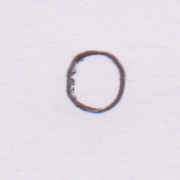

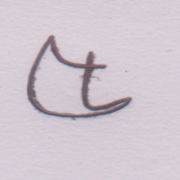

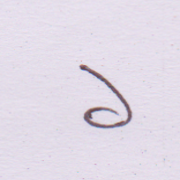

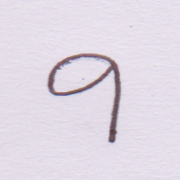

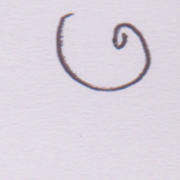

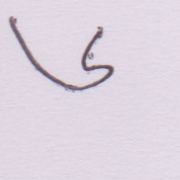

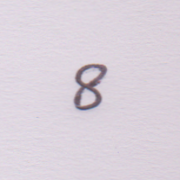

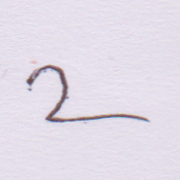

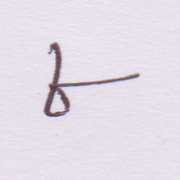

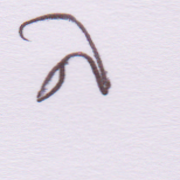

In [5]:
import IPython.display as dp

# collect all .png files in ssample dir
fs = !ls sample/*.png

# create list of image objects
images = []
for ea in fs:
    images.append(dp.Image(filename=ea, format='png'))

# display all images
for ea in images:
    dp.display_png(ea)

# Load All Images

Each class (from 0 to 9) contains almost 500 handwritten bangla digits. Here we manually load each images into spark data-frame with a target column. After loading the whole dataset we split into 8:2 ratio randomly. Thus create a trainig set and test set. Our goal is to train the model with the training data set and finally evaluate the model with test dataset.

In [3]:
import sys, glob, os
sys.path.extend(glob.glob(os.path.join(os.path.expanduser("~"), ".ivy2/jars/*.jar")))

from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import lit

# loaded image
zero_df = ImageSchema.readImages("images/0").withColumn("label", lit(0))
one_df = ImageSchema.readImages("images/1").withColumn("label", lit(1))
two_df = ImageSchema.readImages("images/2").withColumn("label", lit(2))
three_df = ImageSchema.readImages("images/3").withColumn("label", lit(3))
four_df = ImageSchema.readImages("images/4").withColumn("label", lit(4))
five_df = ImageSchema.readImages("images/5").withColumn("label", lit(5))
six_df = ImageSchema.readImages("images/6").withColumn("label", lit(6))
seven_df = ImageSchema.readImages("images/7").withColumn("label", lit(7))
eight_df = ImageSchema.readImages("images/8").withColumn("label", lit(8))
nine_df = ImageSchema.readImages("images/9").withColumn("label", lit(9))


# merge data frame
from functools import reduce

dataframes = [zero_df, one_df, two_df, three_df, 
              four_df,five_df,six_df,seven_df,eight_df,nine_df]

df = reduce(lambda first, second: first.union(second), dataframes)

# repartition dataframe 
df = df.repartition(200)


# # On hot encoding 
# from pyspark.ml.feature import OneHotEncoderEstimator
# encoder = OneHotEncoderEstimator(inputCols=["label"],outputCols=["one_hot_label"])
# model = encoder.fit(df)
# df = model.transform(df)

# split the data-frame
train, test = df.randomSplit([0.8, 0.2], 42)

In [4]:
train.toPandas().head()

,image,label
0,(file:/home/innat/Desktop/PySpark-Deep Learnin...,0
1,(file:/home/innat/Desktop/PySpark-Deep Learnin...,0
2,(file:/home/innat/Desktop/PySpark-Deep Learnin...,1
3,(file:/home/innat/Desktop/PySpark-Deep Learnin...,9
4,(file:/home/innat/Desktop/PySpark-Deep Learnin...,0


In [5]:
df.toPandas().size

1000

In [6]:
df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)
 |-- label: integer (nullable = false)



# Model Training | Transfer Learning with Spark

**Deep Learning Pipelines** enables fast transfer learning with the concept of a Featurizer.

Here we combine the **InceptionV3** model and **logistic regression** in Spark. The **DeepImageFeaturizer** automatically peels off the last layer of a pre-trained neural network and uses the output from all the previous layers as features for the logistic regression algorithm. 

Since logistic regression is a simple and fast algorithm, this transfer learning training can converge quickly using far fewer images than are typically required to train a deep learning model from ground-up.

In [7]:
%%time
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from sparkdl import DeepImageFeaturizer 

# model: InceptionV3
# extracting feature from images
featurizer = DeepImageFeaturizer(inputCol="image", outputCol="features",
                                 modelName="InceptionV3")

# used as a multi class classifier
lr = LogisticRegression(maxIter=5, regParam=0.03, 
                        elasticNetParam=0.5, labelCol="label") 

# define a pipeline model
sparkdn = Pipeline(stages=[featurizer, lr])
spark_model = sparkdn.fit(train)

Using TensorFlow backend.


CPU times: user 1.65 s, sys: 371 ms, total: 2.03 s
Wall time: 3min 8s


# Evaluation

Now, it's time to evaluate the model performance. We now like to evaluate four evaluation matrics such as F1-score, Precision, Recall, Accuracy.

In [8]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# evaluate the model with test set
evaluator = MulticlassClassificationEvaluator() 
transform_test = spark_model.transform(test)

## Evaluation Metrics

In [9]:
print('F1-Score ', evaluator.evaluate(transform_test, 
                                      {evaluator.metricName: 'f1'}))
print('Precision ', evaluator.evaluate(transform_test,
                                       {evaluator.metricName: 'weightedPrecision'}))
print('Recall ', evaluator.evaluate(transform_test, 
                                    {evaluator.metricName: 'weightedRecall'}))
print('Accuracy ', evaluator.evaluate(transform_test, 
                                      {evaluator.metricName: 'accuracy'}))


F1-Score  0.8111782234361806
Precision  0.8422058244785519
Recall  0.8090909090909091
Accuracy  0.8090909090909091


## Confusion Metrix

 Here, we'll summarize the performance of a classification model using the confusion matrix.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
'''
- Convert Spark-DataFrame to Pnadas-DataFrame
- Call Confusion Matrix With 'True' and 'Predicted' Label
'''


from sklearn.metrics import confusion_matrix
y_true = transform_test.select("label")
y_true = y_true.toPandas() # convert to pandas dataframe from spark dataframe

y_pred = transform_test.select("prediction")
y_pred = y_pred.toPandas() # convert to pandas dataframe from spark dataframe

cnf_matrix = confusion_matrix(y_true, y_pred,labels=range(10))

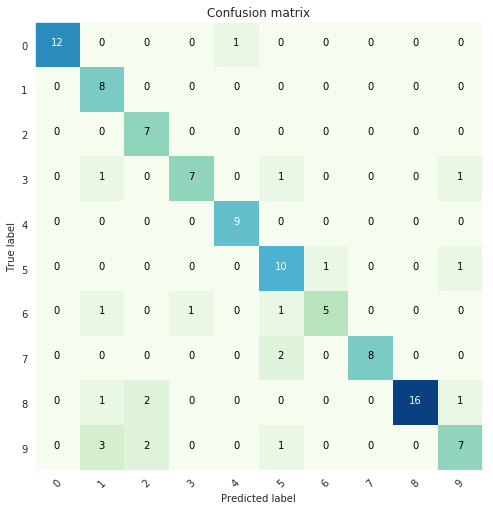

In [14]:
'''
- Visualize the 'Confusion Matrix' 
'''
import seaborn as sns
%matplotlib inline

sns.set_style("darkgrid")
plt.figure(figsize=(7,7))
plt.grid(False)

# call pre defined function
plot_confusion_matrix(cnf_matrix, classes=range(10)) 

## Classification Report

Here we can also get report on classification of each class by the evaluation matrix.

In [15]:
'''
- Classification Report of each class group
'''

from sklearn.metrics import classification_report

target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(y_true, y_pred, target_names = target_names))

              precision    recall  f1-score   support

     Class 0       1.00      0.92      0.96        13
     Class 1       0.57      1.00      0.73         8
     Class 2       0.64      1.00      0.78         7
     Class 3       0.88      0.70      0.78        10
     Class 4       0.90      1.00      0.95         9
     Class 5       0.67      0.83      0.74        12
     Class 6       0.83      0.62      0.71         8
     Class 7       1.00      0.80      0.89        10
     Class 8       1.00      0.80      0.89        20
     Class 9       0.70      0.54      0.61        13

   micro avg       0.81      0.81      0.81       110
   macro avg       0.82      0.82      0.80       110
weighted avg       0.84      0.81      0.81       110



In [16]:
train.count(), test.count()

(390, 110)

## ROC AUC Score

Let's also find ROC AUC socre point of the model

In [18]:
'''
- A custom ROC AUC score function for multi-class classification problem
'''

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_true,y_pred))

ROC AUC score: 0.9005280079560635


## Predicted Samples

Using though a imagenet weight such model really perform pretty promising to recognise handwritten digits. Moreover we didn't also perform any image processing task to better generalization. Also model being trained on very few amounts of data compared to ImageNet dataset where such model is quite fit.

In [19]:
'''
- Comparing true vs predicted samples
'''

# all columns after transformations
print(transform_test.columns)

# see some predicted output
transform_test.select('image', "prediction", "label").show()

['image', 'label', 'features', 'rawPrediction', 'probability', 'prediction']
+--------------------+----------+-----+
|               image|prediction|label|
+--------------------+----------+-----+
|[file:/home/innat...|       1.0|    1|
|[file:/home/innat...|       8.0|    8|
|[file:/home/innat...|       9.0|    9|
|[file:/home/innat...|       1.0|    8|
|[file:/home/innat...|       1.0|    1|
|[file:/home/innat...|       1.0|    9|
|[file:/home/innat...|       0.0|    0|
|[file:/home/innat...|       2.0|    9|
|[file:/home/innat...|       8.0|    8|
|[file:/home/innat...|       9.0|    9|
|[file:/home/innat...|       0.0|    0|
|[file:/home/innat...|       4.0|    0|
|[file:/home/innat...|       5.0|    9|
|[file:/home/innat...|       1.0|    1|
|[file:/home/innat...|       9.0|    9|
|[file:/home/innat...|       9.0|    9|
|[file:/home/innat...|       1.0|    1|
|[file:/home/innat...|       1.0|    1|
|[file:/home/innat...|       9.0|    9|
|[file:/home/innat...|       3.0|    6|
+--